# Dimensionality-Reduction

**Overview**

In this notebook, we will load all maps from the other tutorials (except task-fMRI) and consider the relationships between them. For this, we will apply spatial correlation with the anterior-posterior and proximal-distal axes of the hippocampus, as well as all permutations of rank-ordered subfield labels. Finally, we apply data-driven dimensionality reduction using Gradient decomposition

In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from adjustText import adjust_text
import nibabel as nib
import scipy
from scipy.stats import spearmanr
from itertools import product
import hippomaps as hm
import copy
from brainspace.gradient import GradientMaps
import time
import umap

start_time = time.time()

/export03/data/opt/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# A list of all the data to be examined, grouped roughly into methodologies
files = [
 '../maps/HippoMaps-initializationMaps/Dataset-BigBrain/histology-Merker_average-2_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AxerPLI/histology-PLI-transmittance_average-1_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Bielschowsky_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Blockface_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Parvalbumin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Thionin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calbindin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calretinin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
    
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-R1_average-4_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-R2star_average-4_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-PD_average-4_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-qT1_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-FA_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-ADC_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-T2star_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-MTR_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-IntTS_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-ReHo_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-avgFCneocort_average-99_hemi-L_den-2mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BP-delta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BP-theta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BP-alpha_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BP-beta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BP-gamma_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',

 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-curvature_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-curvature_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-gyrification_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-gyrification_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-thickness_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-thickness_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 ]

In [3]:
# organize into sensible blocks of the same modality
blocks_len = [8,8,3,5,6]
blocks = np.concatenate(([0],np.cumsum(blocks_len)))
# apply a consistent color scheme per methodology
colors = np.hstack((np.ones((blocks_len[0])),np.ones((blocks_len[1]))+1,np.ones((blocks_len[2]))+2,np.ones((blocks_len[3]))+3,np.ones((blocks_len[4]))+4))
# sub label each map within each modality
feature_n = np.array([])
for f in blocks_len:
    feature_n = np.concatenate((feature_n,np.arange(1,f+1)))

## 1) Load all maps and resample

Because these maps have varying resolutions, or surface densities, we will resample them all to 0.5mm vertex spacing

In [4]:
# load all data and resample to a common surface density
features = []
cdata = np.ones((7262,len(files)))
for f in range(len(files)):
    features.append(files[f].split('/')[-1].split('_')[0])
    den = files[f].split('/')[-1].split('_')[3][4:]
    cdata[:,f],_,_ = hm.utils.density_interp(den,'0p5mm',nib.load(files[f]).darrays[0].data, label='hipp')

In [5]:
cmaps = ['Blues','Reds','Greens','Purples','YlOrBr']

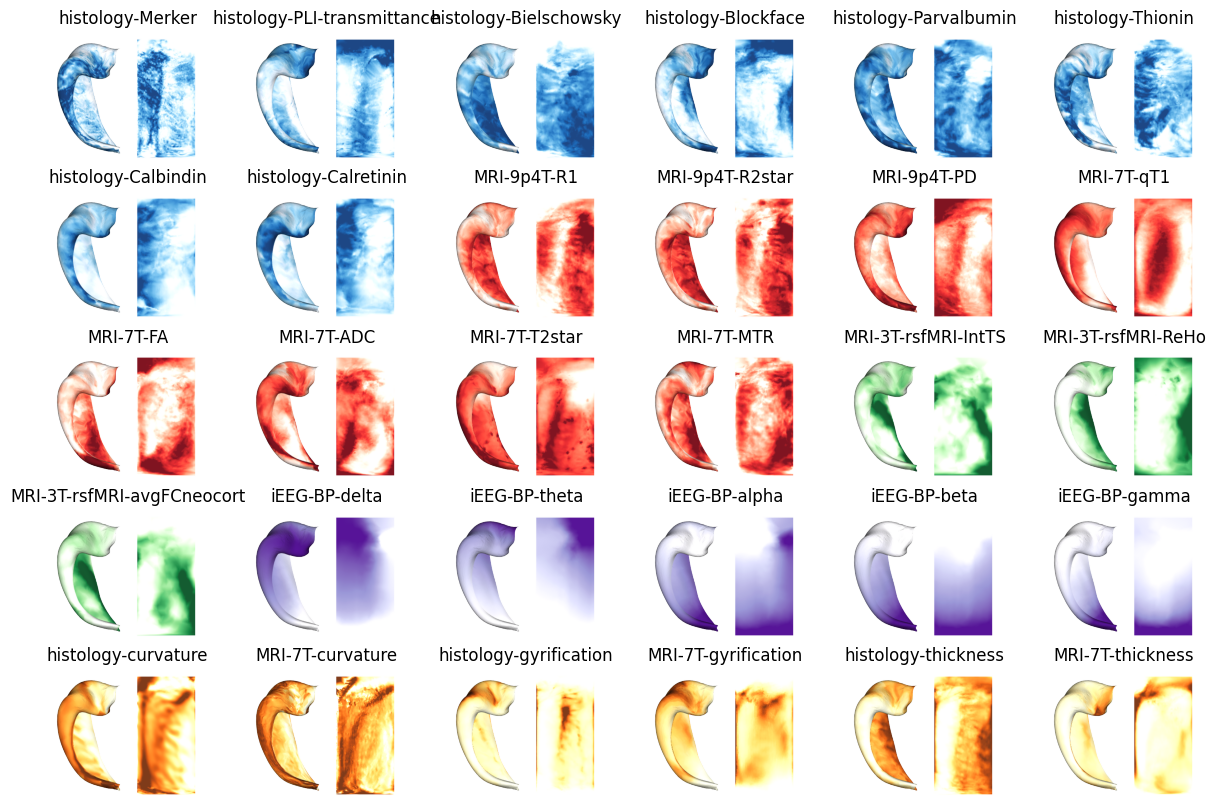

In [24]:
# plot all feature maps in the same plot
# the easiest way to do this is actually to save each set of maps as an image, and then tile all images together

fig, ax = plt.subplots(5,6, figsize=(15,10))

for b in range(30):
    hm.plotting.surfplot_canonical_foldunfold(cdata[:,b], cmap = cmaps[int(colors[b]-1)], hemis=['L'], labels=['hipp'], 
                                              unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, 
                                              filename=f'tmp{b}.png')
    f = plt.imread(f'tmp{b}.png')
    ax[int(b/6),b%6].imshow(f)
    ax[int(b/6),b%6].set_axis_off()
    ax[int(b/6),b%6].set_anchor("NW")
    ax[int(b/6),b%6].set_title(features[b])

#!rm tmp*.png

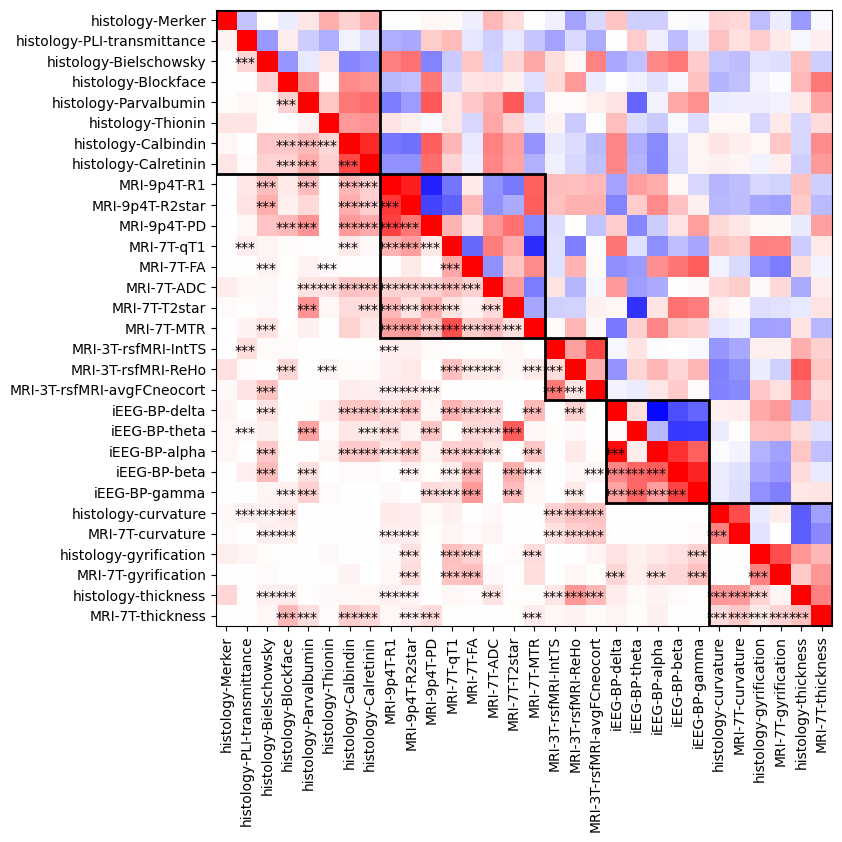

In [14]:
# plot correlation between features

feat_corr = np.corrcoef(cdata.T)

# bottom left will show Rsquared
iloc = np.tril_indices(len(feat_corr))
feat_corr[iloc] = feat_corr[iloc]**2

# plot and label
features_suffix = []
for f,feat in enumerate(features):
    features_suffix.append(feat.split('-')[-1] + ' ' + str(int(feature_n[f])))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(features)),labels=features);
plt.xticks(ticks=range(len(features)),labels=features, rotation=90);

# box around same methodologies
for i in range(len(blocks)-1):
    w = blocks[i+1]-blocks[i]
    rect = Rectangle((blocks[i]-.5,blocks[i]-.5),w,w, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

# check for significant correlation (spin test) (slow!)
nperm = 2 # note that this should be 10000 but for testing we will set it low
feat_corr_p = np.ones((len(features),len(features)))
permutedFeats = []
hm.utils.blockPrint()
for i in range(len(features)):
    for j in range(i+1,len(features)):
        mn,perm,feat_corr_p[i,j],Robs = hm.stats.eigenstrapping(cdata[:,i],cdata[:,j], nperm=nperm)
hm.utils.enablePrint()
# annotate significant correlations
for i in range(len(features)):
    for j in range(i+1,len(features)):
        if feat_corr_p[i,j] < 0.001:
            plt.annotate('***', (i-.6,j+.3));
        elif feat_corr_p[i,j] < 0.01:
            plt.annotate('**', (i-.3,j+.3));
        elif feat_corr_p[i,j] < 0.05:
            plt.annotate('*', (i-.15,j+.3));

## 2) Check for correlations with AP, PD, or subfield organizations

/export03/data/opt/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


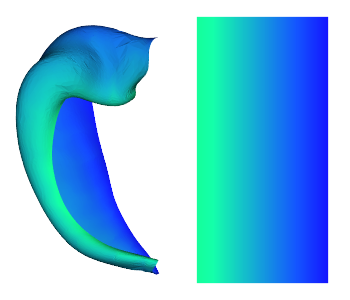

In [15]:
# here we can generate the PD axis. We generate a gradient in a flat 'unfoldiso' density, and then resample it to the present 0p3m surface density
PD,_,_ = hm.utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,126),254,1).T.flatten(), label='hipp')
hm.plotting.surfplot_canonical_foldunfold(PD, hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='winter', tighten_cwindow=False, embed_nb=True)

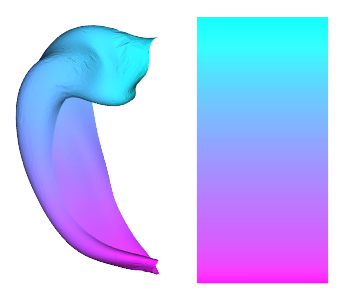

In [16]:
# same as above, for the AP axis
AP,_,_ = hm.utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,254),126,1).flatten(), label='hipp')
hm.plotting.surfplot_canonical_foldunfold(AP, hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='cool', tighten_cwindow=False, embed_nb=True)

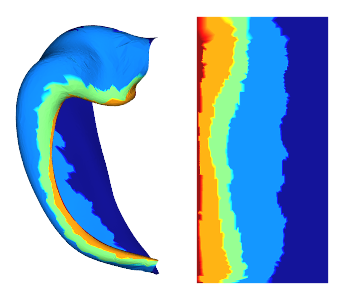

In [17]:
# load subfields from resources
subfields = nib.load(f'../hippomaps/resources/parc-multihist7/sub-0_hemi-0_space-0_den-0p5mm_label-hipp_atlas-multihist7_subfields.label.gii').darrays[0].data
hm.plotting.surfplot_canonical_foldunfold(subfields, hemis=['L'], labels=['hipp'], cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

In [18]:
# generate permutations of subfields labels, since intensities may not change step-wise as they do in our labelling scheme

perms = list(product([1,2,3,4,5],repeat=5))
subfields_permuted = np.ones((len(subfields),len(perms)))*np.nan
for p in range(len(perms)):
    newsf = np.ones((len(subfields)))*np.nan
    for s in range(5):
        newsf[subfields==s+1] = perms[p][s]
    subfields_permuted[:,p] = newsf

Now we can determine whether features are most correlated with the AP axis, PD axis, or permuted subfields

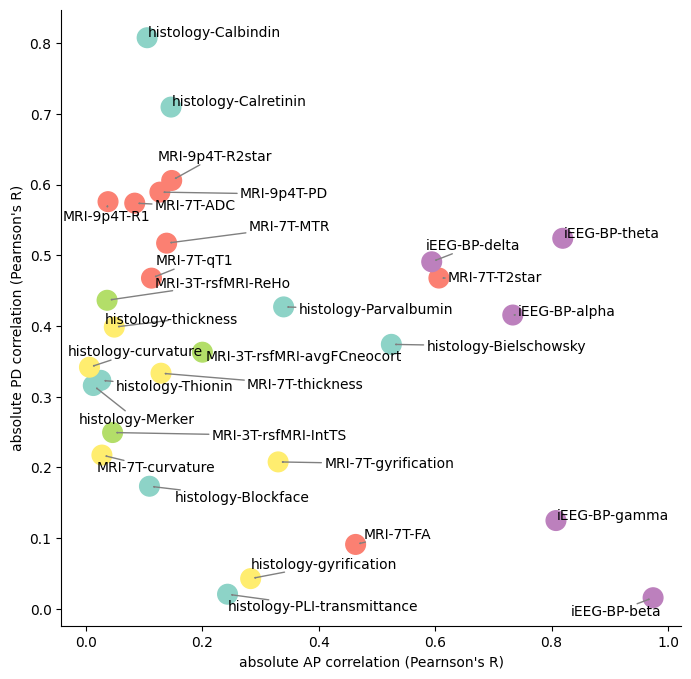

In [19]:
axiscorrAPPD = np.abs(np.corrcoef(np.concatenate((cdata,AP.reshape(7262,1),PD.reshape(7262,1)),axis=1).T)[-2:,:-2])

fig, ax = plt.subplots(figsize=(8,8))
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(axiscorrAPPD[0],axiscorrAPPD[1],c=colors,cmap='Set3', s=200)
plt.xlabel("absolute AP correlation (Pearnson's R)")
plt.ylabel("absolute PD correlation (Pearnson's R)")

texts = [ax.text(axiscorrAPPD[0,f], axiscorrAPPD[1,f], feature, ha='left', va='center') for f,feature in enumerate(features)]
adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));

/export03/data/opt/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


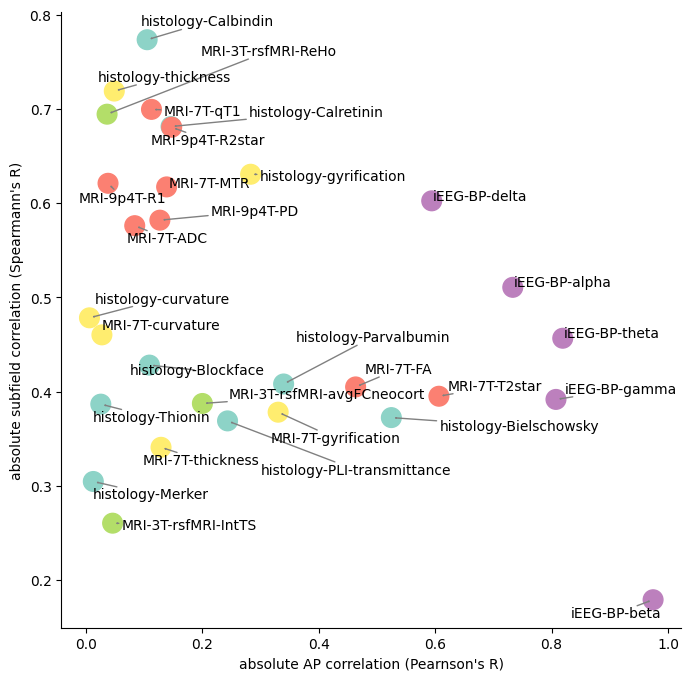

In [20]:
subfieldscorr = np.abs(spearmanr(np.concatenate((cdata,subfields_permuted),axis=1))[0][len(features):,:len(features)])
subfieldsmaxcorr = np.nanmax(subfieldscorr,axis=0)

fig, ax = plt.subplots(figsize=(8,8))
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(axiscorrAPPD[0],subfieldsmaxcorr,c=colors,cmap='Set3',s=200)
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute AP correlation (Pearnson's R)")

texts = [ax.text(axiscorrAPPD[0,f], subfieldsmaxcorr[f], feature, ha='left', va='center') for f,feature in enumerate(features)]
adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));

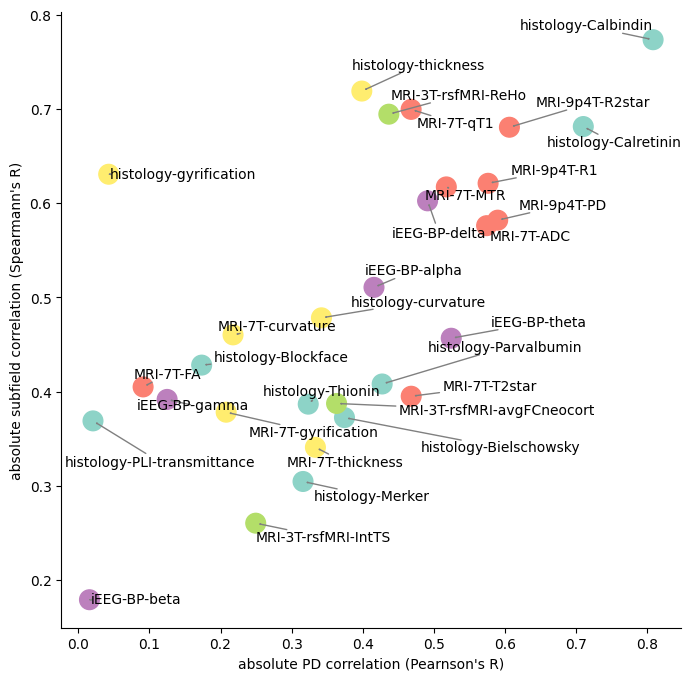

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorrAPPD[1],subfieldsmaxcorr,c=colors,cmap='Set3',s=200)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute PD correlation (Pearnson's R)")

texts = [ax.text(axiscorrAPPD[1,f], subfieldsmaxcorr[f], feature, ha='left', va='center') for f,feature in enumerate(features)]
adjust_text(texts, expand=(1,2), arrowprops=dict(arrowstyle='->', color='gray'));

In [22]:
# save these for adding and comparing with new features using the new function hm.stats.contextualize2D
!mkdir -p ../hippomaps/resources/2Dcontextualize
np.savez_compressed('../hippomaps/resources/2Dcontextualize/initialHippoMaps', features=features, featureData = cdata, feature_n=feature_n, axiscorrAPPD=axiscorrAPPD, subfieldsmaxcorr=subfieldsmaxcorr, AP=AP, PD=PD, subfields_permuted=subfields_permuted, colors=colors)

## 3) Gradient decomposition

Just as in the other tutorials, we will combine features to generate primary gradients. Here, we use all maps, with Pearson's R for for affinity matrix kernel. Since each map is also an average of many subjects, we reduce sparsity from its default 0.9 to 0.1 in order to better leaverage even low values (since we still have high confidence in them)

In [23]:
# gradient decomposition
nGrads=3
mmgm = GradientMaps(kernel='pearson')
mmgm.fit(scipy.stats.zscore(cdata), sparsity=0)

GradientMaps(kernel='pearson')

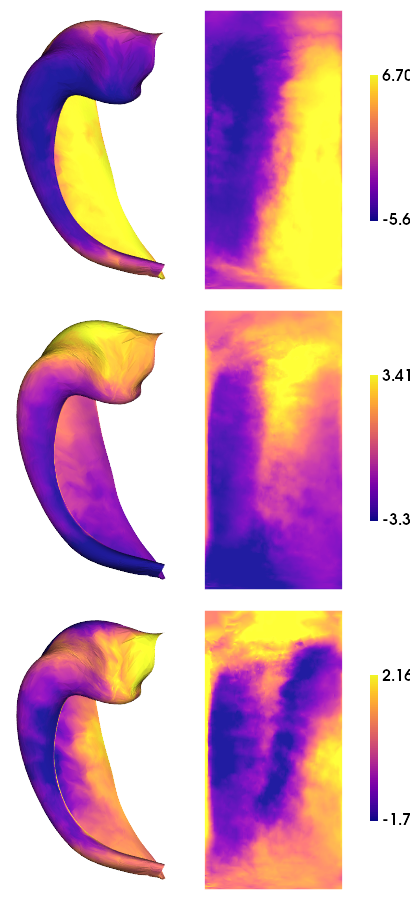

In [24]:
hm.plotting.surfplot_canonical_foldunfold(mmgm.gradients_[:,:nGrads], labels=['hipp'], hemis=['L'], unfoldAPrescale=True, cmap='plasma', color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

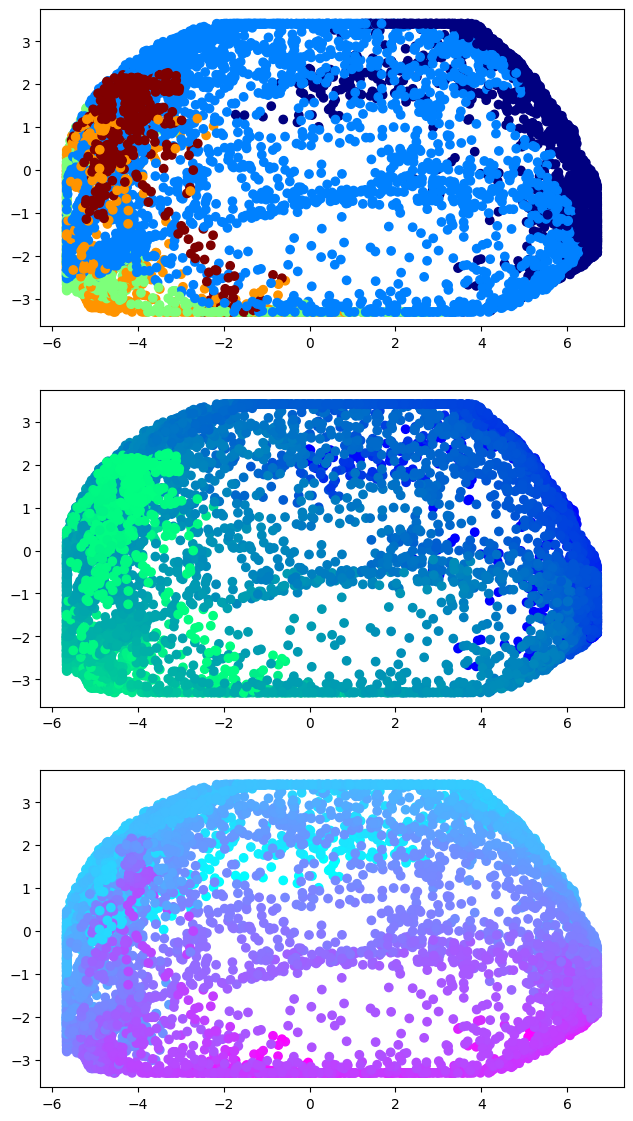

In [25]:
# instead of plotting gradients onto space, we can also plot space into gradients! In this case, space will be the subfield identities, AP coordinates, or PD coordinates

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))#, subplot_kw=dict(projection='3d'))
colouring = [subfields, PD, AP]
cmaps = ['jet','winter','cool']

for c,colour in enumerate(colouring):
    ax[c].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=colour, cmap=cmaps[c])
    ax[c].set_aspect('equal', 'box')
    #ax[c].set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))  # aspect ratio is 1:1:1 in data space

[0.38869746 0.18457567 0.10532194 0.09011365 0.07337068 0.0414355
 0.03563236 0.03383668 0.02564656 0.02136951]
Total duration: 19562.91 seconds


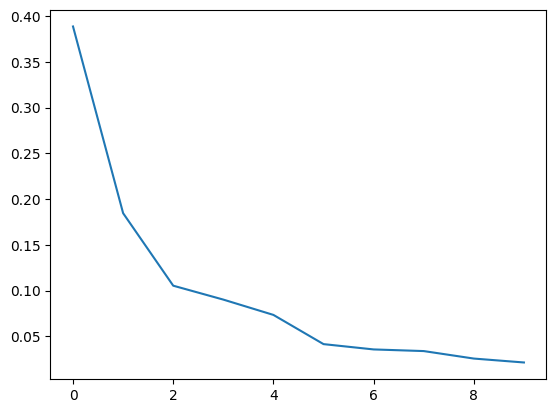

In [26]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mmgm.lambdas_/np.sum(mmgm.lambdas_))
print(mmgm.lambdas_/np.sum(mmgm.lambdas_))

## 4) Other 2D projection methods

Here we explore other projections of vertices or of the various mapping methods/modalities

([], [])

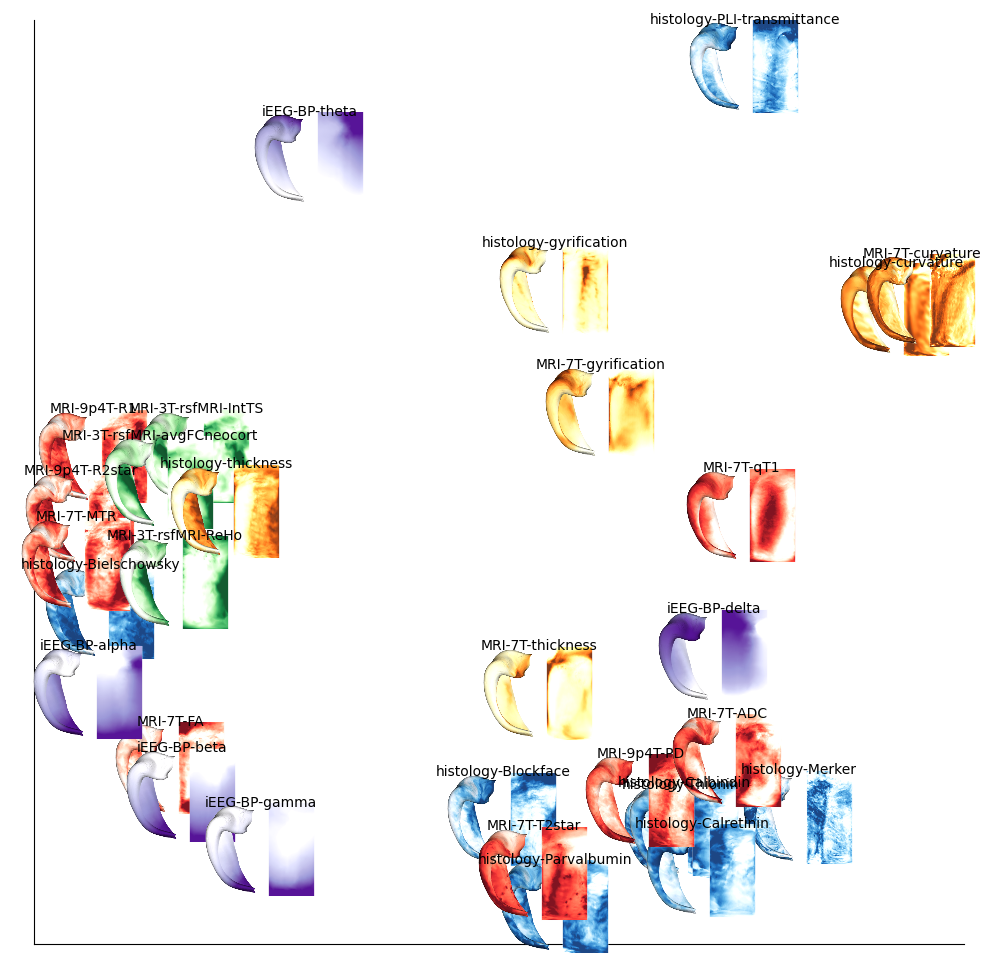

In [50]:
mmgm = GradientMaps(kernel='pearson')
mmgm.fit(scipy.stats.zscore(cdata).T, sparsity=0)
embedding = mmgm.gradients_[:,:2]

fig, ax = plt.subplots(figsize=(12,12))
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(
    embedding[:, 0],
    embedding[:, 1]+.05,
    c=colors,cmap='Set3', alpha=0, s=200)
imgsize = 0.25
for f,feature in enumerate(features):
    ab = AnnotationBbox(getImage(f'tmp{f}.png', zoom=imgsize), (embedding[f, 0], embedding[f, 1]), frameon=False)
    ax.add_artist(ab)
for f,feature in enumerate(features):
    ax.annotate(feature, (embedding[f, 0], embedding[f, 1]+imgsize+.15), ha='center')
plt.xticks([])
plt.yticks([])


/export03/data/opt/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


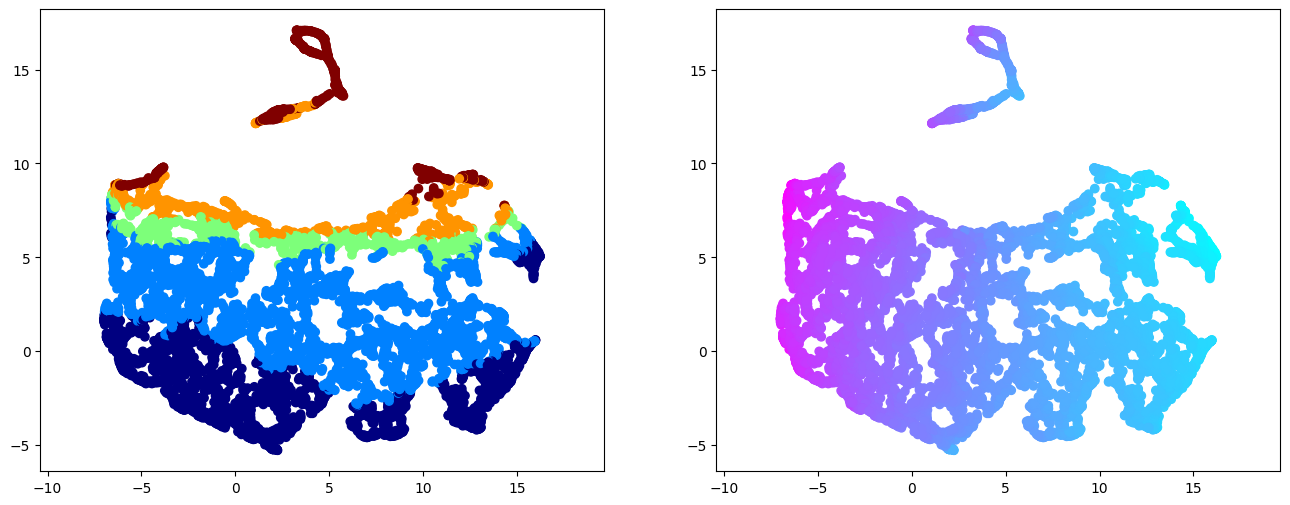

In [27]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scipy.stats.zscore(cdata))

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=subfields, cmap='jet')
plt.gca().set_aspect('equal', 'datalim')

plt.subplot(122)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=AP, cmap='cool')
plt.gca().set_aspect('equal', 'datalim')


/export03/data/opt/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


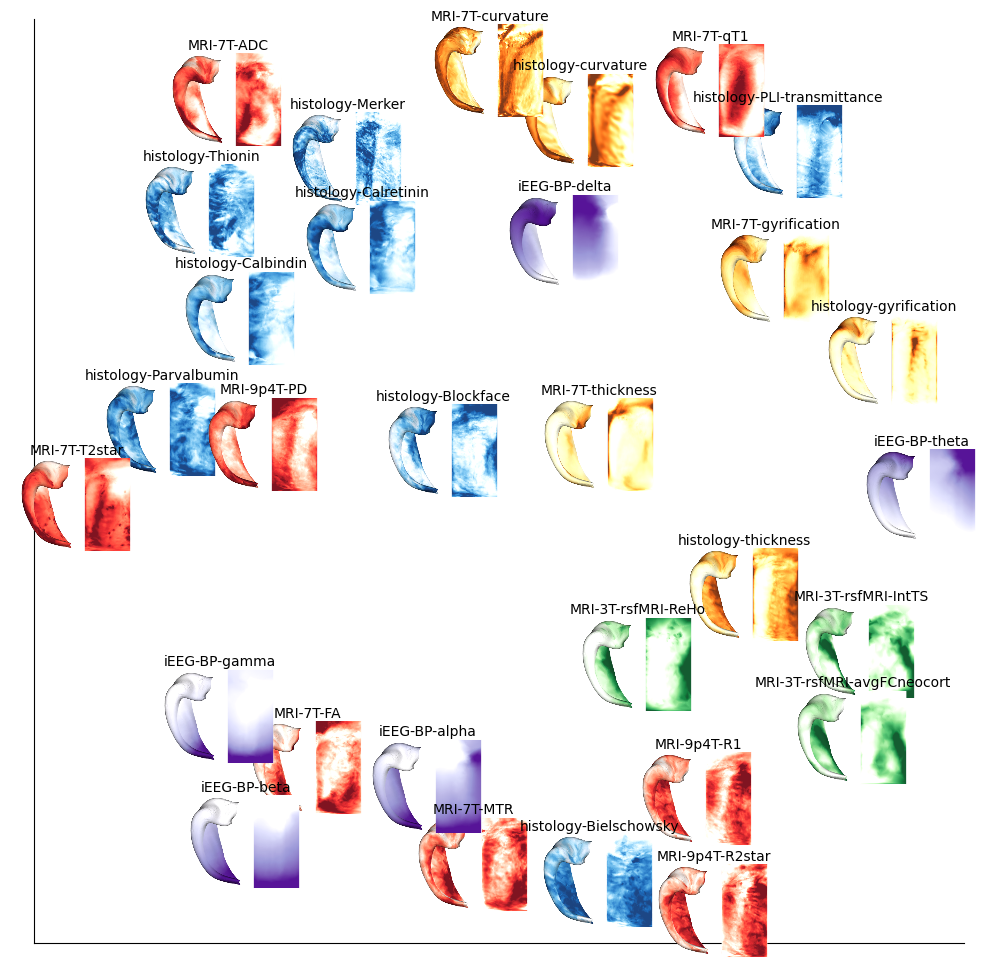

In [51]:
# plot all feature maps in the same plot according to their UMAP similarity

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scipy.stats.zscore(cdata).T)

fig, ax = plt.subplots(figsize=(12,12))
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(
    embedding[:, 0],
    embedding[:, 1]+.05,
    c=colors,cmap='Set3', alpha=0, s=200)
imgsize = 0.25
for f,feature in enumerate(features):
    ab = AnnotationBbox(getImage(f'tmp{f}.png', zoom=imgsize), (embedding[f, 0], embedding[f, 1]), frameon=False)
    ax.add_artist(ab)
for f,feature in enumerate(features):
    ax.annotate(feature, (embedding[f, 0], embedding[f, 1]+imgsize-.01), ha='center')
plt.xticks([])
plt.yticks([])


In [ ]:
!rm tmp*.png

In [29]:
end_time = time.time()
duration = end_time - start_time
print(f"Total duration: {duration:.2f} seconds")